## Proje: E-Ticaret Ürün Segmentasyonu

Amaç:
Ürünleri satış performansı, sipariş sıklığı ve müşteri ilişkilerine göre gruplara (kümelere) ayırmak. Bu segmentasyon, pazarlama stratejileri için kullanılabilir.

 ##  Gerekli Kütüphaneleri Yükle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")


  ## Hedefimiz:
Müşterilerin alışveriş davranışlarına göre segmentlere (kümelere) ayrılması.

In [4]:
import pandas as pd

# Excel dosyasını oku
df = pd.read_excel("Online Retail.xlsx")

# CSV olarak kaydet
df.to_csv("Online Retail.csv", index=False, encoding='utf-8')  # veya ISO-8859-1


In [5]:
import pandas as pd

# CSV dosyanızla aynı klasördeyse sadece dosya adını yazman yeterli
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')  # Türkçe karakterler için encoding önemli

# İlk 5 satırı göster
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


  ## Veri Temizliği
Eksik müşteri ID’si olan satırlar silinir.

Satış adedi (Quantity) veya fiyatı (UnitPrice) sıfır ya da negatif olanlar temizlenir.

TotalPrice isminde yeni bir sütun oluşturulur.

In [8]:
# Eksik değerleri sil (özellikle CustomerID)
df.dropna(subset=['CustomerID'], inplace=True)

# Negatif veya 0 adetli işlemleri kaldır
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Toplam harcama sütunu ekle
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# İlk 5 satırı göster
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Müşteri Bazlı Özellik Mühendisliği

Sipariş sayısı (NumOrders)

Toplam ürün adedi (TotalQuantity)

Toplam harcama (TotalSpent)

Ortalama sipariş başına harcama (AvgSpentPerOrder)

In [9]:
## Müşteri bazlı gruplama
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',        # kaç farklı sipariş
    'Quantity': 'sum',             # toplam ürün adedi
    'TotalPrice': ['sum', 'mean']  # toplam ve ortalama harcama
})

# Sütun isimlerini sadeleştirelim
customer_df.columns = ['NumOrders', 'TotalQuantity', 'TotalSpent', 'AvgSpentPerOrder']
customer_df.reset_index(inplace=True)

# İlk birkaç satırı görelim
customer_df.head()


,CustomerID,NumOrders,TotalQuantity,TotalSpent,AvgSpentPerOrder
0,12346.0,1,74215,77183.60,77183.600000
1,12347.0,7,2458,4310.00,23.681319
2,12348.0,4,2341,1797.24,57.975484
3,12349.0,1,631,1757.55,24.076027
4,12350.0,1,197,334.40,19.670588



Şimdi elimizde müşteri bazlı şu 4 özellik var:

NumOrders: Müşterinin kaç kez alışveriş yaptığı

TotalQuantity: Toplam kaç ürün satın aldığı

TotalSpent: Ne kadar para harcadığı

AvgSpentPerOrder: Sipariş başına ortalama harcama



## Veriyi Ölçekleme (Standardizasyon)
K-Means gibi algoritmalar veri ölçeklerine duyarlıdır. Bu yüzden önce StandardScaler ile verileri aynı ölçeğe getireceğiz.

In [10]:
from sklearn.preprocessing import StandardScaler

# Sadece sayısal sütunlar kullanılacak
features = ['NumOrders', 'TotalQuantity', 'TotalSpent', 'AvgSpentPerOrder']
X = customer_df[features]

# Ölçekleme işlemi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Uygun Küme Sayısını Belirleme (Elbow Yöntemi)
K-Means’te doğru küme sayısını bulmak için Elbow Method kullanılır.

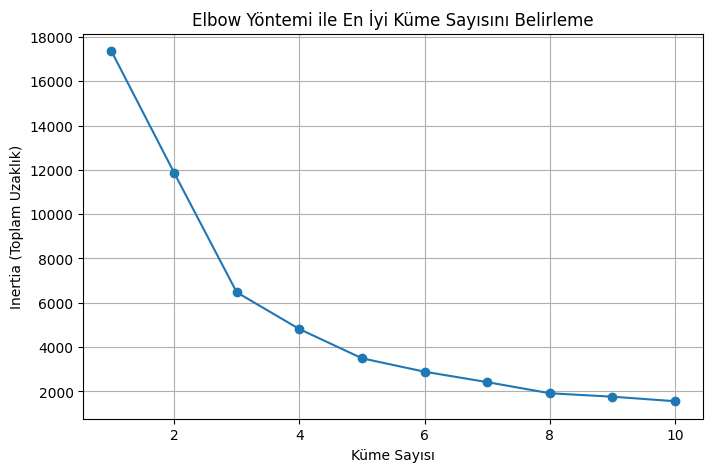

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

# 1'den 10'a kadar küme sayısını dene
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Grafik çizimi
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Küme Sayısı')
plt.ylabel('Inertia (Toplam Uzaklık)')
plt.title('Elbow Yöntemi ile En İyi Küme Sayısını Belirleme')
plt.grid(True)
plt.show()


Grafiğe göre dirsek noktası (elbow) 3 veya 4 kümeye işaret ediyor. Genellikle ilk kırılma noktası seçilir, bu durumda k=3 iyi bir başlangıç.

## K-Means Kümeleme Uygulama
Aşağıdaki kodla modelimizi eğitip, her müşteriye bir segment (küme) atayacağız.

In [12]:
# K-Means modeli eğitimi
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Her kümeden örnek göster
customer_df.groupby('Cluster').mean()

,CustomerID,NumOrders,TotalQuantity,TotalSpent,AvgSpentPerOrder
Cluster,,,,,
0,15300.412827,3.992359,928.879139,1593.554324,36.977749
1,14396.000000,1.500000,77606.000000,122828.050000,66670.550000
2,15405.588235,75.647059,58868.882353,104893.569412,203.323377


Bu çıktı bize:

Hangi kümede kaç sipariş var?

Hangi küme daha çok harcayan müşteri grubu?

Ortalama sipariş miktarları nasıl?

gibi bilgileri verir.

## Kümeleme Sonuçlarını Görselleştirme (PCA)

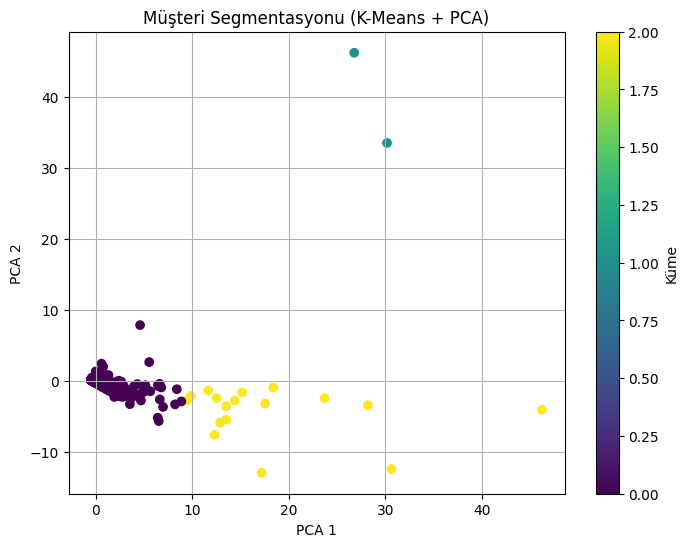

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Grafik çiz
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_df['Cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Müşteri Segmentasyonu (K-Means + PCA)')
plt.colorbar(label='Küme')
plt.grid(True)
plt.show()
